## **to get total number of patches in 3x3 image is divide by size of one patch i.e. 1x1**

(3/1)**2 = 9

Yes, exactly! In short, if the **image size** and **patch size** are square and the patch size divides the image size evenly, you can calculate the total number of patches by:

\[
\text{Total patches} = \left( \frac{\text{Image size}}{\text{Patch size}} \right)^2
\]

For your example:

\[
\text{Total patches} = \left( \frac{3}{1} \right)^2 = 3^2 = 9
\]

This shortcut works because the patches are square and cover the image without overlap or remainder.

In a Vision Transformer (ViT), the total number of patches in an image is calculated by dividing the image's dimensions by the dimensions of a single patch.

For your example:

- **Image size**: \( 3 \times 3 \)
- **Patch size**: \( 1 \times 1 \)

To calculate the total number of patches:

1. **Divide the image dimensions by the patch dimensions**:
   \[
   \text{Number of patches in width (W)} = \frac{\text{Image width}}{\text{Patch width}} = \frac{3}{1} = 3
   \]
   \[
   \text{Number of patches in height (H)} = \frac{\text{Image height}}{\text{Patch height}} = \frac{3}{1} = 3
   \]

2. **Multiply the number of patches along each dimension**:
   \[
   \text{Total number of patches} = \text{W} \times \text{H} = 3 \times 3 = 9
   \]

### Explanation
Each \( 1 \times 1 \) patch is a distinct region of the \( 3 \times 3 \) image. Since the image is perfectly divisible by the patch size, there are \( 9 \) patches in total.

In [1]:
import torch
import torch.nn as nn

In [2]:
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768  # mlp head dimension
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.99)
ACTIVATION = "gelu"
NUM_ENCODERS = 4
EMBED_DIM = PATCH_SIZE * PATCH_SIZE * IN_CHANNELS  # 16   #patch's  W*H*CHEANNELs
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2  # 49


device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"



![alt text](<vit _01.png>)



cls taken has a positional embedding too


In [3]:
import torch.nn as nn


class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()

        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),
            nn.Flatten(2),
        )

        self.cls_token = nn.Parameter(
            torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True
        )  # (batch_size, inn_channels, output_channeks)
        self.position_embeddings = nn.Parameter(
            torch.randn(size=(1, num_patches + 1, embed_dim)), requires_grad=True
        )  # +1 because CLS token is also acting as a batch.. each image patch/token has a positional embeddings correspondent
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(
            x.shape[0], -1, -1
        )  # -1 mean keep dimensoins,,dont chnage them
        # print(f"{cls_token.shape=}")
        x = self.patcher(x).permute(0, 2, 1)
        # now add left cls token to it
        x = torch.cat([cls_token, x], dim=1)
        x = self.position_embeddings + x
        x = self.dropout(x)
        return x


model = PatchEmbedding(
    embed_dim=EMBED_DIM,
    patch_size=PATCH_SIZE,
    num_patches=NUM_PATCHES,
    dropout=DROPOUT,
    in_channels=IN_CHANNELS,
).to(device)

x = torch.randn(512, 1, 28, 28).to(device=device)  # dummy input # b, c, h, w

model(x).shape  # (batch, NUM_PATCHES:49  + 1 for cls, EMBED_DIM

torch.Size([512, 50, 16])

The **[CLS] token** in Vision Transformers (ViT) is a special learnable embedding introduced to aggregate information across all patches for tasks like classification. Here's how it works:

### Purpose of the [CLS] Token
- The **[CLS] token** stands for "classification token."
- It acts as a placeholder for the global representation of the image.
- After the transformer layers process the input patches, the final state of the **[CLS] token** serves as the input to a classification head for downstream tasks (e.g., predicting image labels).

---

### Process in ViT
1. **Input Patches**:
   - The image is divided into fixed-size patches, flattened, and embedded into a sequence of vectors (patch embeddings).
   - Positional embeddings are added to retain spatial information.

2. **[CLS] Token Initialization**:
   - A learnable vector (the [CLS] token) is prepended to the sequence of patch embeddings.
   - The input to the transformer becomes: \([ \text{[CLS]}, P_1, P_2, \dots, P_N ]\), where \(P_i\) are the patch embeddings.

3. **Transformer Processing**:
   - The sequence, including the [CLS] token, is passed through multiple transformer layers.
   - Each layer updates the representation of the [CLS] token based on interactions with the patch embeddings.

4. **Output**:
   - After the final transformer layer, the [CLS] token contains a global representation of the image.
   - This representation is passed to a **classification head** (typically an MLP) for the final prediction.

---

### Why Use the [CLS] Token?
- **Global Aggregation**: The [CLS] token aggregates information from all patches, acting as a summary of the image.
- **Simplicity**: Using a single token for classification avoids the need for pooling operations like average or max pooling.
- **Flexibility**: The same mechanism can be adapted for tasks other than classification by modifying the downstream head.

---

### Example Workflow in ViT
1. **Input Image**: \( 224 \times 224 \) image divided into \( 16 \times 16 \) patches → \( 14 \times 14 = 196 \) patches.
2. **Sequence**: [CLS] + 196 patch embeddings → \( 197 \) tokens.
3. **Output**: Final state of [CLS] → passed to the classification head.

The [CLS] token is central to the ViT architecture, enabling efficient global understanding of the input image.

Yes, in Vision Transformers (**ViT**), the **prediction is based on the [CLS] token**. Here's how it works in detail:

### Why Prediction is Based on [CLS] Token
The **[CLS] token** is designed to serve as a global representation of the input image. During the forward pass through the transformer layers, the [CLS] token interacts with all the patch embeddings and gathers information from the entire image.

After the final transformer layer:
- The [CLS] token contains a summarized feature representation of the image.
- This feature vector is then passed through a **classification head** (e.g., a fully connected layer or MLP) to make the final prediction.

---

### Step-by-Step Process for Prediction

1. **Input Sequence**:
   - The input sequence is \([ \text{[CLS]}, P_1, P_2, \dots, P_N ]\), where \(P_i\) are the patch embeddings, and [CLS] is the classification token.

2. **Transformer Layers**:
   - The sequence is processed by the transformer, and the [CLS] token is updated at each layer through attention with the patch embeddings.

3. **Final [CLS] Token**:
   - After the last transformer layer, the [CLS] token contains a high-level feature vector summarizing the entire image.

4. **Classification Head**:
   - The [CLS] token's final representation is passed through a classification head (e.g., a linear layer with softmax) to predict the image class.

---

### Example
For a classification task:
1. **Input Image**: \(224 \times 224\) image divided into \(16 \times 16\) patches → \(14 \times 14 = 196\) patches.
2. **Input Sequence**: [CLS] + 196 patch embeddings → \(197\) tokens.
3. **Output of Transformer**: Final [CLS] token → \(D\)-dimensional vector (e.g., \(D = 768\)).
4. **Classification**:
   \[
   \text{Prediction} = \text{Softmax}(\text{Linear}(\text{[CLS]}))
   \]

---

### Key Benefits of Using [CLS] Token for Prediction
- **Global Context**: It gathers information from all patches through attention.
- **Simplicity**: Eliminates the need for additional pooling layers like average or max pooling.
- **Flexibility**: Can be adapted for tasks like segmentation or object detection by adding task-specific heads.

Thus, in ViT, the final prediction for classification is **entirely based on the [CLS] token's representation**.

![alt-text](vit_02.png)

In [4]:
class ViT(nn.Module):
    def __init__(
        self,
        num_patches,
        img_size,
        num_classes,
        patch_size,
        embed_dim,
        num_encoders,
        num_head,
        hidden_dim,
        dropout,
        activation,
        in_channels,
    ):
        super().__init__()
        self.embeddings_block = PatchEmbedding(
            embed_dim=embed_dim,
            patch_size=patch_size,
            num_patches=num_patches,
            dropout=dropout,
            in_channels=in_channels,
        )
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_head,
            dropout=dropout,
            activation=activation,
            batch_first=True,  # batch will come first i.e. (B, C,H,W)
            norm_first=True,  # norm before attentiona and mlp lauer
        )
        self.encoder_blocks = nn.TransformerEncoder(
            encoder_layer, num_layers=num_encoders
        )
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes),
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])  # only take 0th token: cls token
        # we dont classify on whole embedding,,instead we only classify on cls token and we only feed cls token to mlp_head
        return x


model = ViT(
    NUM_PATCHES,
    IMG_SIZE,
    NUM_CLASSES,
    PATCH_SIZE,
    EMBED_DIM,
    NUM_ENCODERS,
    NUM_HEADS,
    HIDDEN_DIM,
    DROPOUT,
    ACTIVATION,
    IN_CHANNELS,
).to(device)
y = torch.randn(512, 1, 28, 28).to(device)
model(y).shape

/home/zohaib/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


torch.Size([512, 10])

## training

In [5]:
import pandas
from torch import optim
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [6]:
RANDOM_SEED = 42
EPOCHS = 40
BATCH_SIZE = 512


random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

This code sets a consistent random seed across different libraries and configurations to ensure reproducibility in a machine learning experiment. Let’s break it down:

---

### 1. **Variable Definitions**
- **`RANDOM_SEED = 42`**  
  This is the seed value for random number generation. The choice of `42` is arbitrary and commonly used as a placeholder for deterministic experiments.

- **`EPOCHS = 40` and `BATCH_SIZE = 512`**  
  These variables define the number of training iterations (epochs) and the size of mini-batches for gradient descent, respectively. They are unrelated to the random seed but are typical settings in ML training loops.

---

### 2. **Random Seed Initialization**
- **`random.seed(RANDOM_SEED)`**  
  Sets the seed for Python's built-in `random` module, which is used for generating pseudo-random numbers.

- **`np.random.seed(RANDOM_SEED)`**  
  Sets the seed for NumPy's random number generator. NumPy is often used for array manipulations and operations requiring randomness.

- **`torch.manual_seed(RANDOM_SEED)`**  
  Sets the seed for PyTorch's CPU random number generator, ensuring consistent results for operations involving randomness on the CPU.

- **`torch.cuda.manual_seed(RANDOM_SEED)`**  
  Sets the seed for PyTorch's CUDA random number generator, ensuring consistent results for GPU computations involving randomness.

- **`torch.cuda.manual_seed_all(RANDOM_SEED)`**  
  Similar to `manual_seed`, but ensures that all GPUs (if multiple are used) use the same seed for randomness.

---

### 3. **PyTorch Backend Configuration**
- **`torch.backends.cudnn.deterministic = True`**  
  Ensures deterministic behavior for operations using cuDNN (NVIDIA's library for deep neural networks). When set to `True`, cuDNN uses deterministic algorithms for reproducibility. This may slow down training slightly.

- **`torch.backends.cudnn.benchmark = False`**  
  Disables cuDNN's benchmarking feature, which typically selects the fastest algorithm for a given operation. Turning this off ensures that the same algorithm is used for consistent results, at the cost of potentially reduced performance.

---

### **Purpose and Impact**
By setting all these configurations, the code ensures that:
1. The randomness in data shuffling, weight initialization, and other stochastic operations is consistent across runs.
2. Results from training and evaluation remain reproducible, which is critical for debugging, testing, and sharing research.

However, full reproducibility might still be affected by factors like:
- Differences in hardware or software versions.
- Non-deterministic operations in third-party libraries. 

Using this setup minimizes variability as much as possible.

In [7]:
train_df = pd.read_csv("digit-recognizer/train.csv")
test_df = pd.read_csv("digit-recognizer/test.csv")
submission_df = pd.read_csv("digit-recognizer/sample_submission.csv")

In [8]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [11]:
train_df, val_df = train_test_split(
    train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True
)

In [12]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indices):
        self.images = images
        self.labels = labels
        self.indices = indices
        self.transform = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.RandomRotation(15),  # 15 degrees
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        """return item at a specific index"""
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indices[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

In [13]:
class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indices):
        self.images = images
        self.labels = labels
        self.indices = indices
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        """return item at a specific index"""
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indices[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

In [14]:
class MNISTSubmitDataset(Dataset):
    def __init__(self, images, indices):
        self.images = images
        self.indices = indices
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        """return item at a specific index"""
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        index = self.indices[idx]
        image = self.transform(image)

        return {"image": image, "index": index}

len(train_dataset)=37800
------------------------------
len(val_dataset)=4200
------------------------------
len(test_dataset)=28000
------------------------------


<Figure size 640x480 with 0 Axes>

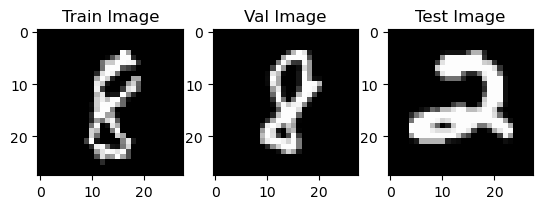

In [15]:
plt.figure()
f, axarr = plt.subplots(1, 3)


train_dataset = MNISTTrainDataset(
    train_df.iloc[:, 1:].values.astype(np.uint8),  # first col is labels
    train_df.iloc[:, 0].values,
    train_df.index.values,
)
print(f"{len(train_dataset)=}")
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap="gray")
axarr[0].set_title("Train Image")
print("-" * 30)


val_dataset = MNISTValDataset(
    val_df.iloc[:, 1:].values.astype(np.uint8),  # first col is labels
    val_df.iloc[:, 0].values,
    val_df.index.values,
)
print(f"{len(val_dataset)=}")
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap="gray")
axarr[1].set_title("Val Image")
print("-" * 30)


test_dataset = MNISTSubmitDataset(
    test_df.values.astype(np.uint8),  # first col is labels
    test_df.index.values,
)

print(f"{len(test_dataset)=}")
axarr[2].imshow(test_dataset[0]["image"].squeeze(), cmap="gray")
axarr[2].set_title("Test Image")
print("-" * 30)

In [16]:
train_df.index[100]

5533

In [17]:
train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True
)


val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
print(f"{device=}")

device='cuda'


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    betas=ADAM_BETAS,
    lr=LEARNING_RATE,
    weight_decay=ADAM_WEIGHT_DECAY,
)

print(f"{device=}")
start = timeit.default_timer()

for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    """
    position=0: Ensures the progress bar appears at a fixed position in the console (useful when running nested loops or multiple progress bars).
    leave=True: Ensures the progress bar remains on the console after the loop finishes. If set to False, the progress bar disappears after completion.
    """
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0

    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(
            label.cpu().detach()
        )  # otherwise you will ru out of menmory
        train_preds.extend(y_pred_label.cpu().detach())

        loss = criterion(y_pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)  # loss for one epoch

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0

    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)

            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
            val_running_loss += loss.item()

    val_loss = val_running_loss / (idx + 1)  # loss for one epoch

    print("-" * 30)
    print(f"train loss epoch {epoch+1}: {train_loss:.4f}")
    print(f"valid loss epoch {epoch+1}: {val_loss:.4f}")
    print(
        f"train_accuracy epoch {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x==y)/len(train_labels):.4f}"
    )
    print(
        f"val_accuracy epoch {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x==y)/len(val_labels):.4f}"
    )
    print("-" * 30)


stop = timeit.default_timer()
print(f"Training time:{stop-start:.2f}s")

device='cuda'


  2%|▎         | 1/40 [00:12<08:24, 12.93s/it]

------------------------------
train loss epoch 1: 2.3019
valid loss epoch 1: 2.1703
train_accuracy epoch 1: 0.1284
val_accuracy epoch 1: 0.2057
------------------------------


  5%|▌         | 2/40 [00:25<08:07, 12.82s/it]

------------------------------
train loss epoch 2: 1.8182
valid loss epoch 2: 1.6061
train_accuracy epoch 2: 0.3697
val_accuracy epoch 2: 0.4931
------------------------------


  8%|▊         | 3/40 [00:38<07:54, 12.82s/it]

------------------------------
train loss epoch 3: 1.5355
valid loss epoch 3: 1.3810
train_accuracy epoch 3: 0.5222
val_accuracy epoch 3: 0.6048
------------------------------


 10%|█         | 4/40 [00:51<07:41, 12.83s/it]

------------------------------
train loss epoch 4: 1.3956
valid loss epoch 4: 1.2495
train_accuracy epoch 4: 0.5910
val_accuracy epoch 4: 0.6662
------------------------------


 12%|█▎        | 5/40 [01:04<07:28, 12.82s/it]

------------------------------
train loss epoch 5: 1.2809
valid loss epoch 5: 1.1320
train_accuracy epoch 5: 0.6383
val_accuracy epoch 5: 0.7110
------------------------------


 15%|█▌        | 6/40 [01:16<07:14, 12.79s/it]

------------------------------
train loss epoch 6: 1.1832
valid loss epoch 6: 1.0488
train_accuracy epoch 6: 0.6783
val_accuracy epoch 6: 0.7395
------------------------------


 18%|█▊        | 7/40 [01:29<07:03, 12.84s/it]

------------------------------
train loss epoch 7: 1.0884
valid loss epoch 7: 0.9663
train_accuracy epoch 7: 0.7149
val_accuracy epoch 7: 0.7681
------------------------------


 20%|██        | 8/40 [01:42<06:52, 12.90s/it]

------------------------------
train loss epoch 8: 1.0127
valid loss epoch 8: 0.8899
train_accuracy epoch 8: 0.7435
val_accuracy epoch 8: 0.7981
------------------------------


 22%|██▎       | 9/40 [01:55<06:41, 12.94s/it]

------------------------------
train loss epoch 9: 0.9471
valid loss epoch 9: 0.8107
train_accuracy epoch 9: 0.7617
val_accuracy epoch 9: 0.8276
------------------------------


 25%|██▌       | 10/40 [02:08<06:28, 12.93s/it]

------------------------------
train loss epoch 10: 0.8795
valid loss epoch 10: 0.7527
train_accuracy epoch 10: 0.7827
val_accuracy epoch 10: 0.8386
------------------------------


 28%|██▊       | 11/40 [02:21<06:13, 12.88s/it]

------------------------------
train loss epoch 11: 0.8238
valid loss epoch 11: 0.6909
train_accuracy epoch 11: 0.7975
val_accuracy epoch 11: 0.8488
------------------------------


 30%|███       | 12/40 [02:34<06:00, 12.87s/it]

------------------------------
train loss epoch 12: 0.7708
valid loss epoch 12: 0.6579
train_accuracy epoch 12: 0.8127
val_accuracy epoch 12: 0.8600
------------------------------


 32%|███▎      | 13/40 [02:47<05:47, 12.89s/it]

------------------------------
train loss epoch 13: 0.7350
valid loss epoch 13: 0.6243
train_accuracy epoch 13: 0.8198
val_accuracy epoch 13: 0.8602
------------------------------


 35%|███▌      | 14/40 [03:00<05:35, 12.90s/it]

------------------------------
train loss epoch 14: 0.6920
valid loss epoch 14: 0.5992
train_accuracy epoch 14: 0.8292
val_accuracy epoch 14: 0.8607
------------------------------


 38%|███▊      | 15/40 [03:13<05:23, 12.92s/it]

------------------------------
train loss epoch 15: 0.6499
valid loss epoch 15: 0.5410
train_accuracy epoch 15: 0.8391
val_accuracy epoch 15: 0.8771
------------------------------


 40%|████      | 16/40 [03:26<05:10, 12.93s/it]

------------------------------
train loss epoch 16: 0.6167
valid loss epoch 16: 0.5237
train_accuracy epoch 16: 0.8446
val_accuracy epoch 16: 0.8843
------------------------------


 42%|████▎     | 17/40 [03:39<04:58, 13.00s/it]

------------------------------
train loss epoch 17: 0.5814
valid loss epoch 17: 0.4990
train_accuracy epoch 17: 0.8560
val_accuracy epoch 17: 0.8831
------------------------------


 45%|████▌     | 18/40 [03:52<04:46, 13.01s/it]

------------------------------
train loss epoch 18: 0.5608
valid loss epoch 18: 0.4540
train_accuracy epoch 18: 0.8563
val_accuracy epoch 18: 0.8914
------------------------------


 48%|████▊     | 19/40 [04:05<04:33, 13.00s/it]

------------------------------
train loss epoch 19: 0.5261
valid loss epoch 19: 0.4377
train_accuracy epoch 19: 0.8653
val_accuracy epoch 19: 0.8976
------------------------------


 50%|█████     | 20/40 [04:18<04:19, 12.99s/it]

------------------------------
train loss epoch 20: 0.5139
valid loss epoch 20: 0.4153
train_accuracy epoch 20: 0.8657
val_accuracy epoch 20: 0.8998
------------------------------


 52%|█████▎    | 21/40 [04:31<04:06, 12.95s/it]

------------------------------
train loss epoch 21: 0.4817
valid loss epoch 21: 0.3957
train_accuracy epoch 21: 0.8722
val_accuracy epoch 21: 0.9017
------------------------------


 55%|█████▌    | 22/40 [04:44<03:52, 12.93s/it]

------------------------------
train loss epoch 22: 0.4674
valid loss epoch 22: 0.3849
train_accuracy epoch 22: 0.8754
val_accuracy epoch 22: 0.9090
------------------------------


 57%|█████▊    | 23/40 [04:56<03:38, 12.88s/it]

------------------------------
train loss epoch 23: 0.4442
valid loss epoch 23: 0.3829
train_accuracy epoch 23: 0.8795
val_accuracy epoch 23: 0.9076
------------------------------


 60%|██████    | 24/40 [05:09<03:26, 12.88s/it]

------------------------------
train loss epoch 24: 0.4214
valid loss epoch 24: 0.3562
train_accuracy epoch 24: 0.8870
val_accuracy epoch 24: 0.9100
------------------------------


 62%|██████▎   | 25/40 [05:22<03:13, 12.88s/it]

------------------------------
train loss epoch 25: 0.4091
valid loss epoch 25: 0.3313
train_accuracy epoch 25: 0.8879
val_accuracy epoch 25: 0.9095
------------------------------


 65%|██████▌   | 26/40 [05:35<03:00, 12.89s/it]

------------------------------
train loss epoch 26: 0.3887
valid loss epoch 26: 0.3168
train_accuracy epoch 26: 0.8935
val_accuracy epoch 26: 0.9183
------------------------------


 68%|██████▊   | 27/40 [05:48<02:47, 12.87s/it]

------------------------------
train loss epoch 27: 0.3767
valid loss epoch 27: 0.3379
train_accuracy epoch 27: 0.8961
val_accuracy epoch 27: 0.9052
------------------------------


 70%|███████   | 28/40 [06:01<02:34, 12.91s/it]

------------------------------
train loss epoch 28: 0.3648
valid loss epoch 28: 0.3286
train_accuracy epoch 28: 0.8978
val_accuracy epoch 28: 0.9112
------------------------------


 72%|███████▎  | 29/40 [06:14<02:22, 12.93s/it]

------------------------------
train loss epoch 29: 0.3504
valid loss epoch 29: 0.3194
train_accuracy epoch 29: 0.9019
val_accuracy epoch 29: 0.9117
------------------------------


 75%|███████▌  | 30/40 [06:27<02:09, 12.91s/it]

------------------------------
train loss epoch 30: 0.3323
valid loss epoch 30: 0.2858
train_accuracy epoch 30: 0.9066
val_accuracy epoch 30: 0.9179
------------------------------


 78%|███████▊  | 31/40 [06:39<01:55, 12.88s/it]

------------------------------
train loss epoch 31: 0.3340
valid loss epoch 31: 0.2744
train_accuracy epoch 31: 0.9052
val_accuracy epoch 31: 0.9236
------------------------------


 80%|████████  | 32/40 [06:52<01:42, 12.87s/it]

------------------------------
train loss epoch 32: 0.3176
valid loss epoch 32: 0.2670
train_accuracy epoch 32: 0.9089
val_accuracy epoch 32: 0.9269
------------------------------


 82%|████████▎ | 33/40 [07:05<01:30, 12.92s/it]

------------------------------
train loss epoch 33: 0.3143
valid loss epoch 33: 0.2711
train_accuracy epoch 33: 0.9083
val_accuracy epoch 33: 0.9276
------------------------------


 85%|████████▌ | 34/40 [07:18<01:17, 12.94s/it]

------------------------------
train loss epoch 34: 0.2990
valid loss epoch 34: 0.2349
train_accuracy epoch 34: 0.9124
val_accuracy epoch 34: 0.9333
------------------------------


 88%|████████▊ | 35/40 [07:31<01:04, 12.93s/it]

------------------------------
train loss epoch 35: 0.2874
valid loss epoch 35: 0.2681
train_accuracy epoch 35: 0.9165
val_accuracy epoch 35: 0.9281
------------------------------


 90%|█████████ | 36/40 [07:44<00:51, 12.88s/it]

------------------------------
train loss epoch 36: 0.2934
valid loss epoch 36: 0.2486
train_accuracy epoch 36: 0.9139
val_accuracy epoch 36: 0.9324
------------------------------


 92%|█████████▎| 37/40 [07:57<00:38, 12.87s/it]

------------------------------
train loss epoch 37: 0.2745
valid loss epoch 37: 0.2186
train_accuracy epoch 37: 0.9202
val_accuracy epoch 37: 0.9360
------------------------------


 95%|█████████▌| 38/40 [08:10<00:25, 12.86s/it]

------------------------------
train loss epoch 38: 0.2724
valid loss epoch 38: 0.2322
train_accuracy epoch 38: 0.9187
val_accuracy epoch 38: 0.9305
------------------------------


 98%|█████████▊| 39/40 [08:23<00:12, 12.87s/it]

------------------------------
train loss epoch 39: 0.2613
valid loss epoch 39: 0.2141
train_accuracy epoch 39: 0.9231
val_accuracy epoch 39: 0.9374
------------------------------


100%|██████████| 40/40 [08:35<00:00, 12.90s/it]

------------------------------
train loss epoch 40: 0.2553
valid loss epoch 40: 0.2231
train_accuracy epoch 40: 0.9229
val_accuracy epoch 40: 0.9393
------------------------------
Training time:515.89s


In [20]:
torch.cuda.empty_cache()  # to free gpu space
"""torch.cuda.empty_cache() is a PyTorch function that frees up unused GPU memory in the cache, making it available for other operations. This can be helpful when you encounter GPU memory issues, but it doesn't directly reduce the memory used by your tensors or computations. It simply clears memory that PyTorch's caching allocator is holding onto for potential reuse."""

"torch.cuda.empty_cache() is a PyTorch function that frees up unused GPU memory in the cache, making it available for other operations. This can be helpful when you encounter GPU memory issues, but it doesn't directly reduce the memory used by your tensors or computations. It simply clears memory that PyTorch's caching allocator is holding onto for potential reuse."

In [22]:
labels = []
ids = []
imgs = []
model.eval()

with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i) + 1 for i in sample["index"]])

        outputs = model(img)
        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

100%|██████████| 55/55 [00:02<00:00, 20.50it/s]


<Figure size 640x480 with 0 Axes>

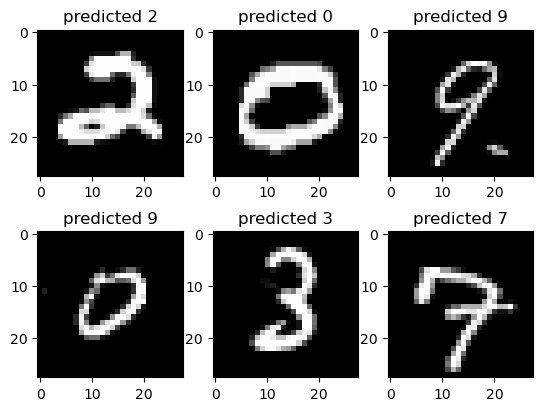

In [24]:
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"predicted {labels[counter]}")
        counter += 1


plt.show()